# Project 3

| Name | ID |
|-----------|-----|
| Hsien-Chih Hung | 104466136 |
| Trung Le | 205223834 |
| Radhika Nayar | 805226085 |
| Juan Rebanal | 005227239 |

## Reinforcement Learning (RL)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

R1 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

R2 = np.array([[0, 0, 0, 0,    0,    0,    0,    0,    0,  0], 
               [0, 0, 0, 0, -100, -100, -100,    0,    0,  0], 
               [0, 0, 0, 0, -100,    0, -100,    0,    0,  0], 
               [0, 0, 0, 0, -100,    0, -100, -100, -100,  0], 
               [0, 0, 0, 0, -100,    0,    0,    0, -100,  0], 
               [0, 0, 0, 0, -100,    0,    0,    0, -100,  0], 
               [0, 0, 0, 0, -100,    0,    0,    0, -100,  0], 
               [0, 0, 0, 0,    0,    0, -100, -100, -100,  0], 
               [0, 0, 0, 0,    0,    0, -100,    0,    0,  0], 
               [0, 0, 0, 0,    0,    0,    0,    0,    0, 10]])

In [0]:
class MDP:
    
    def __init__(self, R, w=0.1, gamma=0.8, is_improved=False):
        self.S = range(100)             # state space
        self.A = range(4)               # action space {0=Right, 1=Up, 2=Left, 3=Down}
        self.gamma = gamma              # discount factor
        self.w = w                      # transition prob
        self.R = R                      # Reward function
        self.V = None                   # Value function
        self.P = None                   # Optimal policy 
        self.Pa = []                    # Probability transition matrices
        self.is_improved = is_improved  # if want to further fix go-off-grid discrepancy
        self.value_iteration()
        self.create_prob_trans_matrices()
        
    def inspect_neighbors(self,x,y):
        
        # What neighbors does that state have? Start by assuming it has 4 neighbors
        # on its right, up, left, and down (0, 1, 2, 3)
        neighbors = {0: 1, 1: 1, 2: 1, 3: 1}

        if y + 1 > 9:
            neighbors[0] = 0

        if x - 1 < 0:
            neighbors[1] = 0

        if y - 1 < 0:
            neighbors[2] = 0

        if x + 1 > 9:
            neighbors[3] = 0
            
        return neighbors
    
    def create_prob_trans_matrices(self):
        # Create an empty matrix for each action
        m = n = len(self.S)
        
        for action in self.A:
            self.Pa.append(np.zeros ((m, n)))
            
        # Fill each probability transition matrix
        
        for a in self.A:         # Action: 0/1/2/3 right/up/left/down
            for i in range(m):   # Current state. Pick THIS row of probability trans matrix to fill a column at a time

                x = i % 10
                y = i // 10
                    
                neighbors = self.inspect_neighbors(x,y)
                    
                for action in self.A:
                    if action == a: # If iterating through expected action a
                        if a == 0:
                            if neighbors[0]:
                                self.Pa[a][i, i + 10] += 1 - 3*self.w/4
                            else:
                                self.Pa[a][i, i] += 1 - 3*self.w/4
                        elif a == 1:
                            if neighbors[1]:
                                self.Pa[a][i, i - 1] += 1 - 3*self.w/4
                            else: 
                                self.Pa[a][i, i] += 1 - 3*self.w/4
                        elif a == 2:
                            if neighbors[2]:
                                self.Pa[a][i, i - 10] += 1 - 3*self.w/4
                            else:
                                self.Pa[a][i, i] += 1 - 3*self.w/4
                        else:
                            if neighbors[3]:
                                self.Pa[a][i, i + 1] += 1 - 3*self.w/4
                            else:
                                self.Pa[a][i, i] += 1 - 3*self.w/4

                    else: # If iterating through the 'mistaken' actions 
                        if action == 0:
                            if neighbors[0]:
                                self.Pa[a][i, i + 10] += self.w/4
                            else:
                                self.Pa[a][i, i] += self.w/4
                        elif action == 1:
                            if neighbors[1]:
                                self.Pa[a][i, i - 1] += self.w/4
                            else: 
                                self.Pa[a][i, i] += self.w/4
                        elif action == 2:
                            if neighbors[2]:
                                self.Pa[a][i, i - 10] += self.w/4
                            else:
                                self.Pa[a][i, i] += self.w/4
                        else:
                            if neighbors[3]:
                                self.Pa[a][i, i + 1] += self.w/4
                            else:
                                self.Pa[a][i, i] += self.w/4

                    
                    
    def value_iteration(self):
        # Initialization
        m, n = self.R.shape
        self.V = np.zeros((m,n))
        self.P = np.zeros((m,n))
        delta = 1
        # Estimation
        while delta > 0.009:

            delta = 0
            for x in range(m):
                for y in range(n):

                    prev = self.V[x,y]
                    val = self.look_ahead(x,y)["v"]
                    self.V[x,y] = val
                    delta = max(delta, np.abs(val - prev))
        # Computation
        for x in range(m):
            for y in range(n):
                self.P[x,y] = self.look_ahead(x,y)["a"]
            
    
    def look_ahead(self, x, y):
        A = {0:"Right", 1:"Up", 2:"Left", 3:"Down"}
        value_list = [self.get_val(x, y, a) for a in A.keys()]
        opt_a = np.argmax(value_list)
        if self.is_improved:
            neighbors = self.inspect_neighbors(x,y)
            i = 2
            while neighbors[opt_a] == 0: # no neighbor in the optimal direction    
                opt_a = np.argsort(value_list)[-i] # choose the next largest value instead
                i += 1
        return {"v":value_list[opt_a], "a":opt_a} 

    
    
    def get_val(self, x, y, a):
        m, n = self.R.shape
        p = [1/4 * self.w ] *4 
        p[a] = 1 - 3/4 * self.w
        r = np.array([self.R[x,min(y+1,n-1)], self.R[max(x-1,0),y],
                      self.R[x,max(y-1,0)], self.R[min(x+1,m-1),y]])
        v = np.array([self.V[x,min(y+1,n-1)], self.V[max(x-1,0),y],
                      self.V[x,max(y-1,0)], self.V[min(x+1,m-1),y]])
        return np.sum(p * (r + self.gamma * v))
        
        
    def show_R(self):
        fig = plt.figure(figsize=(10,6))
        m, n = self.R.shape
        for x in range(m):
            for y in range(n):
                plt.text(y+0.5, x+0.5, '%.2f'%self.R[x, y],
                         horizontalalignment='center',
                         verticalalignment='center')
        plt.pcolor(self.R, cmap="coolwarm", alpha=0.5)
        plt.xticks(np.arange(0, 10, 1))
        plt.yticks(np.arange(9, -1, -1))
        plt.axis([0, 10, 10, 0])
        plt.colorbar()
        plt.show()
        
        
    def show_V(self):
        fig = plt.figure(figsize=(10,6))
        m, n = self.V.shape
        for x in range(m):
            for y in range(n):
                plt.text(y+0.5, x+0.5, '%.2f'%self.V[x, y],
                         horizontalalignment='center',
                         verticalalignment='center')
        plt.pcolor(self.V, cmap="coolwarm", alpha=0.5)
        plt.xticks(np.arange(0, 10, 1))
        plt.yticks(np.arange(9, -1, -1))
        plt.axis([0, 10, 10, 0])
        plt.colorbar()
        plt.grid()
        plt.show()
        
        
    def show_P(self):
        fig = plt.figure(figsize=(8,6))
        m, n = self.P.shape
        x = np.arange(0.5, m, 1)
        y = np.arange(0.5, n, 1)
        U = np.cos(self.P * np.pi / 2)
        V = np.sin(self.P * np.pi / 2)
        plt.quiver(x, y, U, V, pivot='middle')
        plt.xticks(np.arange(0, 10, 1))
        plt.yticks(np.arange(9, -1, -1))
        plt.axis([0, 10, 10, 0])
        plt.grid()
        plt.show()


### Q1

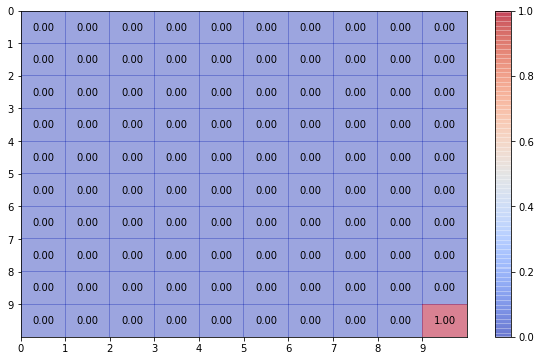

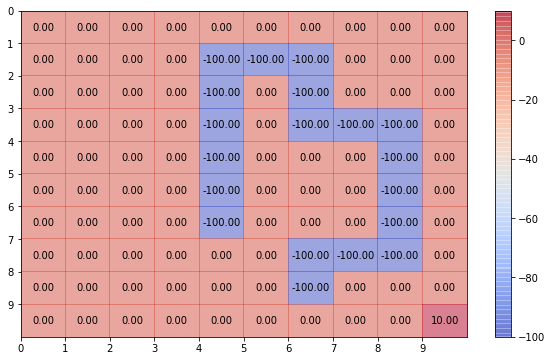

In [0]:
# create MDP instances
mdp1 = MDP(R1, w=0.1, gamma=0.8)
mdp2 = MDP(R2, w=0.1, gamma=0.8)

# Q1
mdp1.show_R()
mdp2.show_R()

### Q2-5

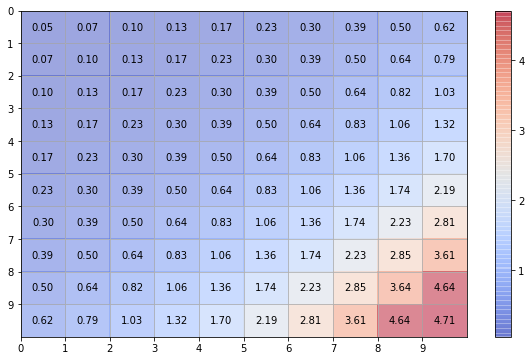

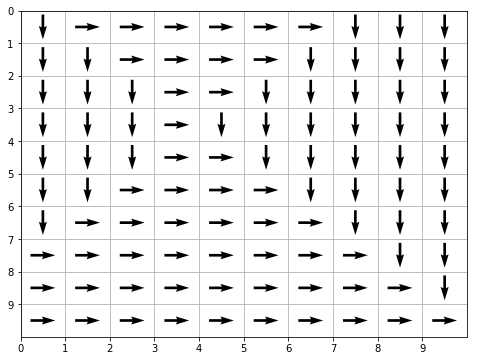

In [0]:
# Q2-5
mdp1.show_V()
mdp1.show_P()

### Q6-9

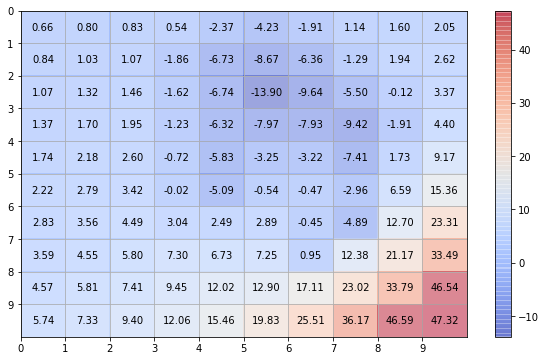

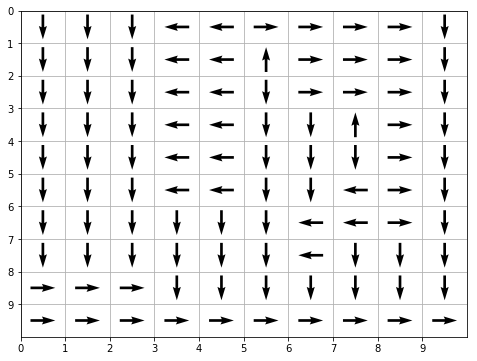

In [0]:
# Q6-9
mdp2.show_V()
mdp2.show_P()

## Inverse Reinforcement learning (IRL)

In [0]:
import cvxopt

def irl(mdp, coeff_lambda):
    
    R_max = mdp.R.max()
    P_opt = mdp.P.T.reshape((100,))
    
    def LP(tpm, optimal_action, gamma, act, s):
        a = tpm[int(optimal_action[s])][s] - tpm[act][s]      
        b = np.linalg.inv(np.eye(100) - gamma * tpm[int(optimal_action[s])])
        return np.dot(a,b)
        
    P = -np.vstack([LP(mdp.Pa, P_opt, 0.8, a, s) 
                        for s in mdp.S for a in set(mdp.A) - {P_opt[s]}])
    
    P_ = np.vstack([np.eye(1, 100, s) 
                            for s in mdp.S for a in set(mdp.A) - {P_opt[s]}])
        
    # D 
    D11 = P
    D12 = P_
    D13 = np.zeros((300, 100))
    D21 = P
    D22 = np.zeros((300, 100))
    D23 = np.zeros((300, 100))
    D31 = np.eye(100)
    D32 = np.zeros((100, 100))
    D33 = -np.eye(100)
    D41 = -np.eye(100)
    D42 = np.zeros((100, 100))
    D43 = -np.eye(100)
    D51 = np.eye(100)
    D52 = np.zeros((100, 100))
    D53 = np.zeros((100, 100))
    D61 = -np.eye(100)
    D62 = np.zeros((100, 100))
    D63 = np.zeros((100, 100))
    D1 = np.hstack([D11, D12, D13])
    D2 = np.hstack([D21, D22, D23])
    D3 = np.hstack([D31, D32, D33])
    D4 = np.hstack([D41, D42, D43])
    D5 = np.hstack([D51, D52, D53])
    D6 = np.hstack([D61, D62, D63])
    D = cvxopt.matrix(np.vstack([D1, D2, D3, D4, D5, D6]))
    
    # c
    c1 = np.zeros((100,))
    c2 = np.ones((100,))
    c3 = -1 * coeff_lambda * np.ones((100,))
    c = -1 * cvxopt.matrix(np.hstack([c1, c2, c3]).T)
    # b
    b = np.concatenate((np.zeros(800), np.full((200,), R_max)))
    b = cvxopt.matrix(b)
        
    cvxopt.solvers.options['show_progress'] = False
    result = cvxopt.solvers.lp(c, D, b)
    return np.squeeze(result['x'][:100]).reshape((10, 10)).T
    

def plot_acc(R, is_improved=False):
    m, n = R.shape
    accuracies = []
    mdp = MDP(R, w=0.1, gamma=0.8, is_improved=is_improved)
    lambdas = np.linspace(0, 5, 501)
    for l in lambdas:
        R_ = irl(mdp, l)
        OA = MDP(R_, w=0.1, gamma=0.8, is_improved=is_improved).P
        acc = np.count_nonzero(OA == mdp.P)/(m*n)
        accuracies.append(acc)
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(lambdas, accuracies)
    plt.show()
    
    lambda_opt = lambdas[np.argmax(accuracies)]
    return lambda_opt, accuracies

### Q11

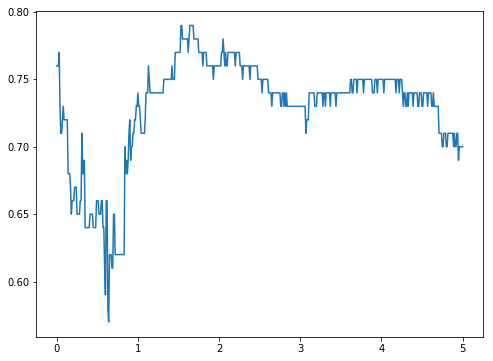

In [0]:
lambda_opt, accuracies = plot_acc(R1)

### Q12

In [0]:
print("optimal lambda =", lambda_opt)
print("best accuracy =", np.max(accuracies))

optimal lambda = 1.53
best accuracy = 0.79


### Q13

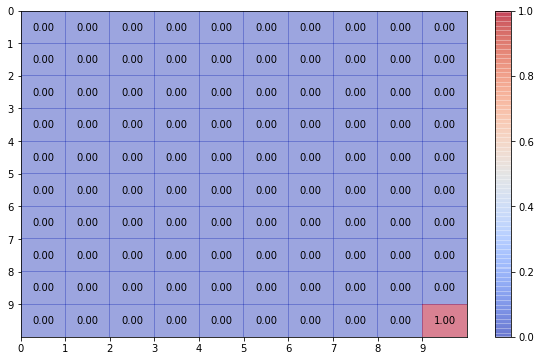

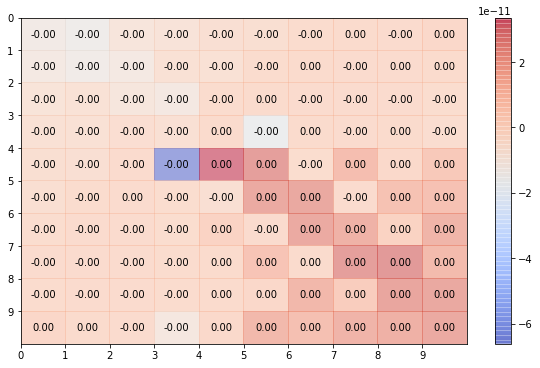

In [0]:
expert = MDP(R1, w=0.1, gamma=0.8)
expert.show_R()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_R()

### Q14 + Q15

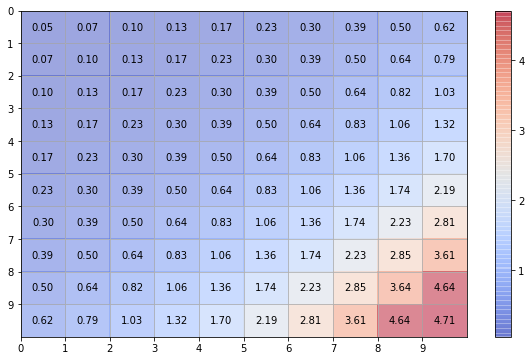

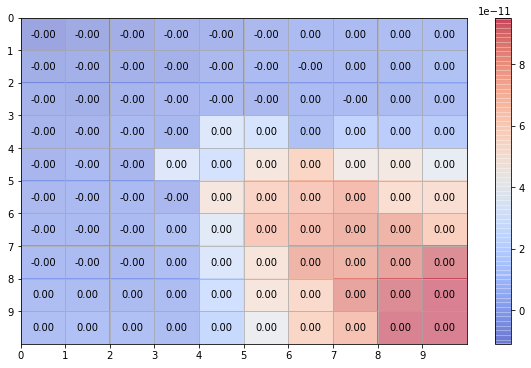

In [0]:
expert = MDP(R1, w=0.1, gamma=0.8)
expert.show_V()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_V()

### Q16 + Q17

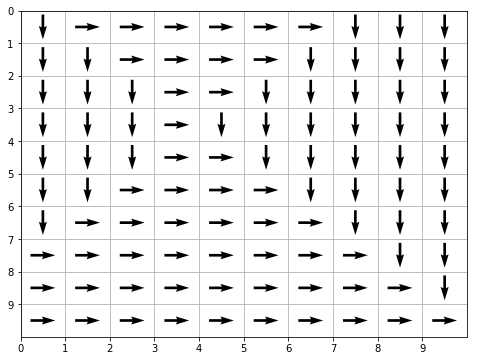

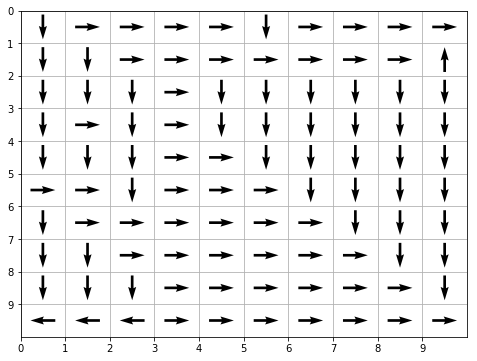

In [0]:
expert = MDP(R1, w=0.1, gamma=0.8)
expert.show_P()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_P()

### Q18

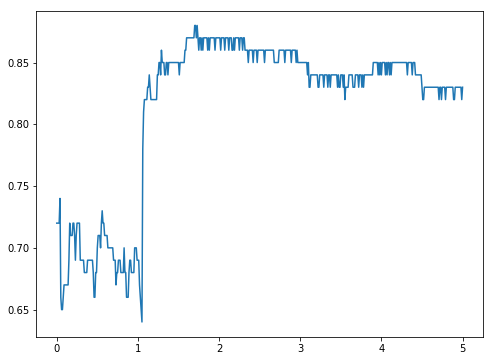

In [0]:
lambda_opt, accuracies = plot_acc(R2)

### Q19

In [0]:
print("optimal lambda =", lambda_opt)
print("best accuracy =", np.max(accuracies))

optimal lambda = 1.7
best accuracy = 0.88


### Q20

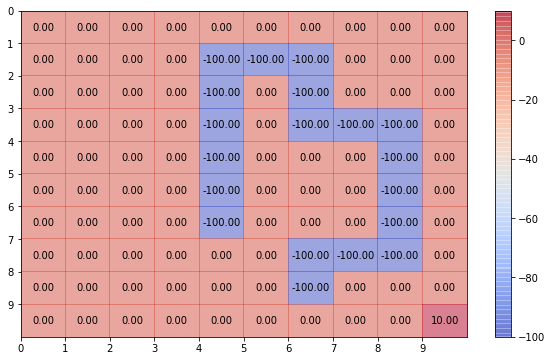

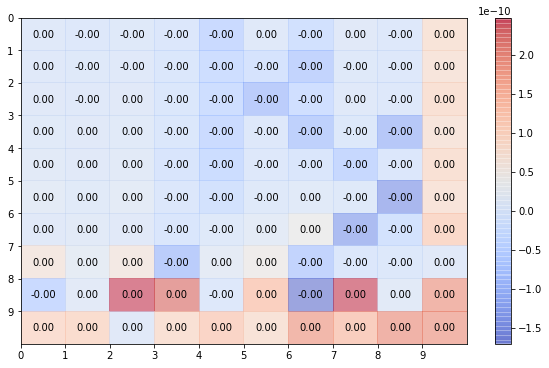

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8)
expert.show_R()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_R()

### Q21 + Q22

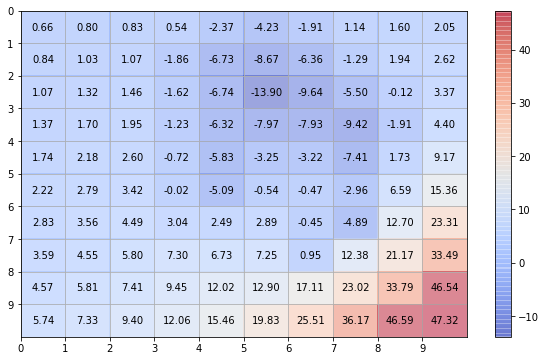

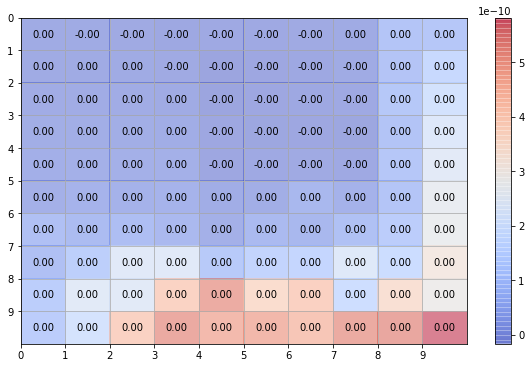

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8)
expert.show_V()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_V()

### Q23 + Q24

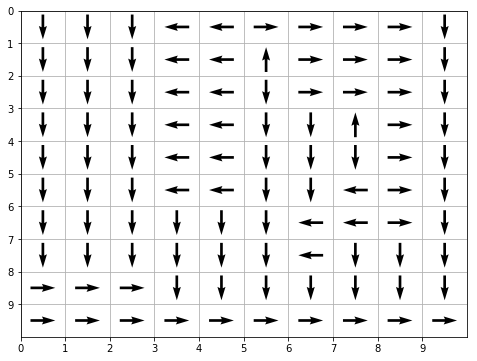

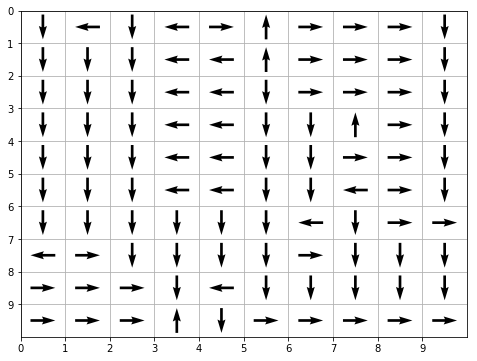

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8)
expert.show_P()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8)
agent.show_P()

### Q25

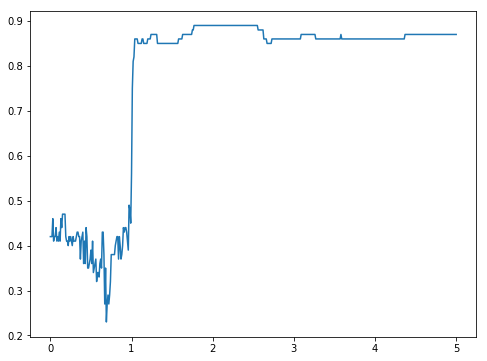

In [0]:
lambda_opt, accuracies = plot_acc(R2, is_improved=True)

In [0]:
print("optimal lambda =", lambda_opt)
print("best accuracy =", np.max(accuracies))

optimal lambda = 1.77
best accuracy = 0.89


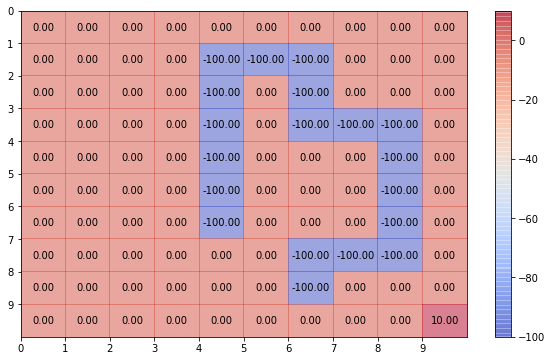

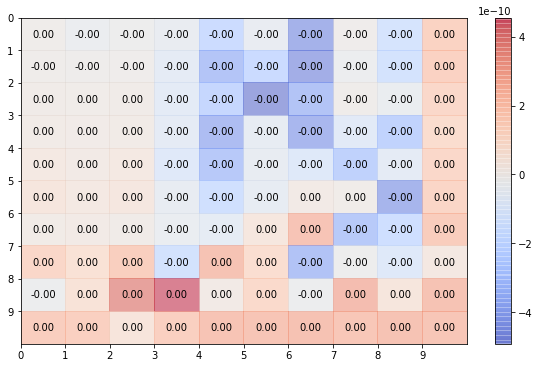

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8, is_improved=True)
expert.show_R()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8, is_improved=True)
agent.show_R()

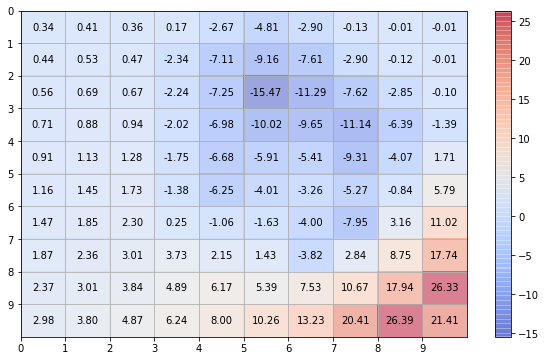

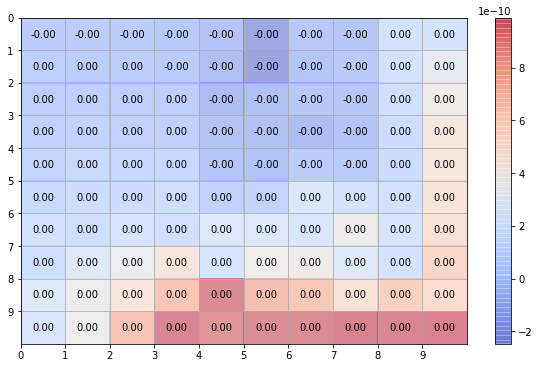

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8, is_improved=True)
expert.show_V()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8, is_improved=True)
agent.show_V()

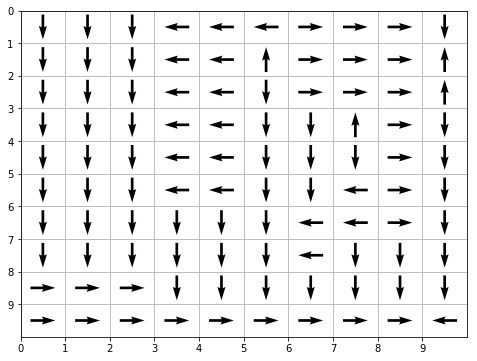

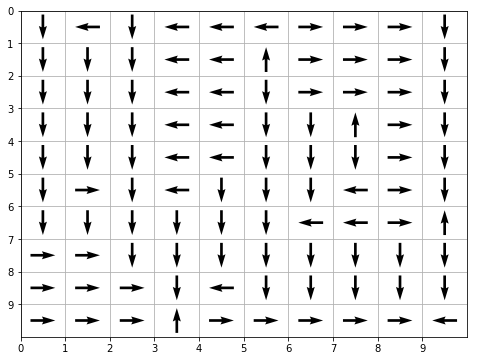

In [0]:
expert = MDP(R2, w=0.1, gamma=0.8, is_improved=True)
expert.show_P()
R_ = irl(expert, lambda_opt)
agent = MDP(R_, w=0.1, gamma=0.8, is_improved=True)
agent.show_P()